In [1]:
%cd ../..
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/jupyter/map-ephys


In [ ]:
import multiprocessing as mp
pool = mp.Pool(4)

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

import dill
import scipy

# cache_folder = '~/s3-drive/report/st_cache/'
cache_folder = '/home/jupyter/s3-drive/export/'

# cache_folder = '/root/capsule/data/s3/export/'

session_keys =  dill.load(open(cache_folder + 'session_keys.pkl', 'rb'))
session_keys

[{'subject_id': 473360, 'session': 49},
 {'subject_id': 473360, 'session': 50},
 {'subject_id': 473360, 'session': 51},
 {'subject_id': 473360, 'session': 52},
 {'subject_id': 473361, 'session': 47},
 {'subject_id': 473361, 'session': 57},
 {'subject_id': 473361, 'session': 59},
 {'subject_id': 473361, 'session': 60},
 {'subject_id': 482353, 'session': 33},
 {'subject_id': 482353, 'session': 34},
 {'subject_id': 482353, 'session': 36},
 {'subject_id': 482353, 'session': 37},
 {'subject_id': 482353, 'session': 42},
 {'subject_id': 482353, 'session': 43},
 {'subject_id': 482353, 'session': 45},
 {'subject_id': 494691, 'session': 17},
 {'subject_id': 494691, 'session': 18}]

In [ ]:
from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf, report, psth_foraging
from pipeline.plot import behavior_plot, unit_characteristic_plot, unit_psth, histology_plot, PhotostimError, foraging_plot
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice, plot_unit_all_in_one
foraging_sessions = (foraging_analysis.SessionTaskProtocol & 'session_task_protocol=100').proj()
import datajoint as dj; dj.conn().connect()

# PSTH refactor

## Aligned Spikes

In [3]:
psth_foraging.UnitTrialAlignedSpikes

pipeline.psth_foraging.UnitTrialAlignedSpikes

In [267]:
psth_foraging.UnitTrialAlignedSpikes.populate(display_progress=True)

In [23]:
psth_foraging.UnitTrialAlignedSpikes.progress()

UnitTrialAlignedSpikes Completed 15003 of 15003 (100.0%)   2022-12-16 21:48:07


(0, 15003)

## PSTHs

In [ ]:
psth_foraging.UnitPSTHChoiceOutcome.key_source - psth_foraging.UnitPSTHChoiceOutcome

In [26]:
psth_foraging.UnitPSTHChoiceOutcome.populate(display_progress=True)

UnitPSTHChoiceOutcome: 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


In [60]:
psth_foraging.UnitPSTHChoiceOutcome.progress()

UnitPSTHChoiceOutcome Completed 15003 of 15003 (100.0%)   2022-12-16 21:56:08


(0, 15003)

In [33]:
key = {'subject_id': 473360,
  'session': 49,
  'insertion_number': 2,
  'clustering_method': 'kilosort2',
  'unit': 568,
  'align_type_name': 'choice',
  'choice': 'contra',
  'outcome': 'hit'}

In [218]:
psth_foraging.UnitPSTHChoiceOutcome.heading

# 
subject_id           : int                          # institution 6 digit animal ID
session              : smallint                     # session number
insertion_number     : int                          # 
clustering_method    : varchar(16)                  # 
unit                 : smallint                     # 
align_type_name      : varchar(32)                  # user-friendly name of alignment type
choice               : varchar(10)                  # 'ipsi', 'contra', 'ignore'
outcome              : varchar(10)                  # 'hit', 'miss', 'ignore'
---
raw                  : longblob                     # spike times in this condition
trials               : longblob                     # trial numbers used in this condition
psth                 : longblob                     # binned firing rate (mean +/- sem)
psth_filtered        : longblob                     # filtered by causal half Gaussian (mean +/- sem)
ts                   : longblob                     # time c

In [98]:
psth_foraging.UnitPSTHChoiceOutcome().delete()

[2022-12-16 18:21:10,015][INFO]: Deleting 70014 rows from `map_v2_psth_foraging`.`__unit_p_s_t_h_choice_outcome`


Commit deletes? [yes, No]:  yes
Deletes committed.


70014

In [75]:
schema = psth_foraging.schema

In [80]:
psth_foraging.UnitPSTHChoiceOutcome().populate(display_progress=True, reserve_jobs=True)

UnitPSTHChoiceOutcome: 100%|██████████| 4185/4185 [06:03<00:00, 11.50it/s]


In [ ]:
class UnitPSTHChoiceOutcome(dj.Computed):
    definition = """
    -> ephys.Unit 
    -> AlignType
    choice:    varchar(10)   # 'ipsi', 'contra', 'ignore'
    outcome:   varchar(10)   # 'hit', 'miss', 'ignore'
    ---
    raw:    longblob      # spike times in this condition
    trials:     longblob  # trial numbers used in this condition
    psth:      longblob   # binned firing rate (mean +/- sem)
    psth_filtered:   longblob  # filtered by causal half Gaussian (mean +/- sem)
    ts:      longblob  # time centers
    """

In [4]:
key_source = dj.U(*(ephys.Unit.heading.primary_key), 'align_type_name') & psth_foraging.UnitTrialAlignedSpikes  # Remove `trial` field
choices = ['contra', 'ipsi']
outcome = ['hit', 'miss']
if_exclude_early_lick=False

bin_size = 0.01
gaussian_sigma = 0.05

In [5]:
key = key_source.fetch('KEY', limit=1)[0]
key

{'subject_id': 473360,
 'session': 49,
 'insertion_number': 2,
 'clustering_method': 'kilosort2',
 'unit': 0,
 'align_type_name': 'choice'}

In [21]:
key = {'subject_id': 482353, 'session': 34, 'insertion_number': 2, 'clustering_method': 'kilosort2', 'unit': 394, 'align_type_name': 'choice'}
key

{'subject_id': 482353,
 'session': 34,
 'insertion_number': 2,
 'clustering_method': 'kilosort2',
 'unit': 394,
 'align_type_name': 'choice'}

In [5]:
import scipy.ndimage

def halfgaussian_kernel1d(sigma, radius):
    """
    Computes a 1-D Half-Gaussian convolution kernel.
    """
    sigma2 = sigma * sigma
    x = np.arange(0, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()

    return phi_x

def halfgaussian_filter1d(input, sigma, axis=-1, output=None,
                      mode="constant", cval=0.0, truncate=4.0):
    """
    Convolves a 1-D Half-Gaussian convolution kernel.
    """
    sd = float(sigma)
    # make the radius of the filter equal to truncate standard deviations
    lw = int(truncate * sd + 0.5)
    weights = halfgaussian_kernel1d(sigma, lw)
    origin = -lw // 2
    return scipy.ndimage.convolve1d(input, weights, axis, output, mode, cval, origin)

In [36]:
key =  {'subject_id': 473360,
  'session': 49,
  'insertion_number': 2,
  'clustering_method': 'kilosort2',
  'unit': 568,
  'align_type_name': 'choice',
  'choice': 'contra',
  'outcome': 'hit'}

In [37]:
no_early_lick = '_noearlylick' if if_exclude_early_lick else ''
offset, psth_win = (psth_foraging.AlignType & key).fetch1('trial_offset', 'psth_win')

hemi = (ephys.Unit * histology.ElectrodeCCFPosition.ElectrodePosition.proj(hemi='IF(ccf_x > 5739, "L", "R")') & key).fetch1('hemi')
ipsi = hemi
contra = list({"L", "R"} - {ipsi})[0]

# Get trials
condition_mapping = {('contra', 'hit'): f'{contra}_hit{no_early_lick}',
                     # ('contra', 'miss'): f'{contra}_miss{no_early_lick}',
                     # ('ipsi', 'hit'): f'{ipsi}_hit{no_early_lick}',
                     # ('ipsi', 'miss'): f'{ipsi}_miss{no_early_lick}',
                     # ('ignore', 'ignore'): 'ignore',
                    }

for (choice, outcome), condition_str in condition_mapping.items():
    q_this = psth_foraging.TrialCondition.get_trials(condition_str, offset) & key
    trials, spikes_aligned = (psth_foraging.UnitTrialAlignedSpikes & key & q_this).fetch('trial', 'aligned_spikes')
    if not len(trials): continue

    bins = np.arange(psth_win[0], psth_win[1], bin_size)
    ts = np.mean([bins[1:], bins[:-1]], axis=0)

    # PSTH
    psth_per_trial = np.vstack([np.histogram(trial_spike, bins=bins)[0] / bin_size for trial_spike in spikes_aligned])    
    psth = np.mean(psth_per_trial, axis=0)
    sem = np.std(psth_per_trial, axis=0) / np.sqrt(len(q_this))

    # Gaussian filter
    psth_per_trial_filtered = halfgaussian_filter1d(psth_per_trial, sigma=gaussian_sigma/bin_size)
    psth_filtered = np.mean(psth_per_trial_filtered, axis=0)
    sem_filtered = np.std(psth_per_trial_filtered, axis=0) / np.sqrt(len(q_this))
  

In [38]:
trials

array([  1,   7,  59,  67,  69,  73,  76,  80,  83,  86,  94,  96, 104,
       109, 114, 115, 117, 123, 129, 132, 136, 138, 140, 147, 150, 152,
       153, 154, 155, 156, 160, 164, 165, 166, 168, 172, 179, 183, 187,
       188, 190, 199, 204, 214, 243, 252, 253, 254, 255, 257, 258, 261,
       263, 265, 273, 274, 275, 276, 278, 279, 283, 284, 285, 287, 288,
       293, 295, 296, 350, 356, 357, 360, 361, 366, 367, 368, 370, 378,
       388, 390, 391, 396, 398, 400, 402, 404, 411, 413, 416, 417, 421,
       422, 426, 428, 429, 434, 439, 443, 446, 449, 492, 496, 499, 500,
       505, 506, 507, 508, 510, 517, 524, 528, 531, 536, 542, 543, 546,
       555, 558, 564, 567, 568, 569, 570, 571, 580, 581, 590, 627, 628,
       629, 630, 633, 637, 638, 642, 643, 644, 646, 648, 650, 657, 659,
       673, 675, 676, 678, 681, 683, 684, 685, 687, 688, 690, 691, 692,
       693, 694, 695, 696, 697, 698, 726])

In [43]:
from pipeline.util import _get_unit_independent_variable, _get_units_hemisphere
_get_units_hemisphere(key)

[autoreload of pipeline.psth_foraging failed: Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/opt/conda/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/opt/conda/lib/python3.7/site-packages/IPython/exte

'left'

In [32]:
(ephys.Unit * histology.ElectrodeCCFPosition.ElectrodePosition.proj(hemi='IF(ccf_x > 5739, "L", "R")') & key)

subject_id institution 6 digit animal ID,session session number,insertion_number,clustering_method,unit,probe_type e.g. neuropixels_1.0,electrode_config_name user friendly name,electrode_group electrode group,"electrode electrode index, starts at 0",ccf_label_id Local CCF ID,ccf_x (um),ccf_y (um),ccf_z (um),unit_uid unique across sessions/animals,unit_quality,"unit_posx (um) estimated x position of the unit relative to probe's tip (0,0)","unit_posy (um) estimated y position of the unit relative to probe's tip (0,0)",spike_times (s) from the start of the first data point used in clustering,spike_sites array of electrode associated with each spike,spike_depths (um) array of depths associated with each spike,unit_amp,unit_snr,waveform average spike waveform,hemi calculated attribute


In [37]:
ephys.Unit & key

subject_id institution 6 digit animal ID,session session number,insertion_number,clustering_method,unit,unit_uid unique across sessions/animals,unit_quality,probe_type e.g. neuropixels_1.0,electrode_config_name user friendly name,electrode_group electrode group,"electrode electrode index, starts at 0","unit_posx (um) estimated x position of the unit relative to probe's tip (0,0)","unit_posy (um) estimated y position of the unit relative to probe's tip (0,0)",spike_times (s) from the start of the first data point used in clustering,spike_sites array of electrode associated with each spike,spike_depths (um) array of depths associated with each spike,unit_amp,unit_snr,waveform average spike waveform
482353,34,2,kilosort2,394,394,good,neuropixels 1.0 - 3B,1-384,0,373,27.0,3720.0,=BLOB=,=BLOB=,=BLOB=,187.0288944723618,10.052190043582106,=BLOB=


(0.0, 1.0)

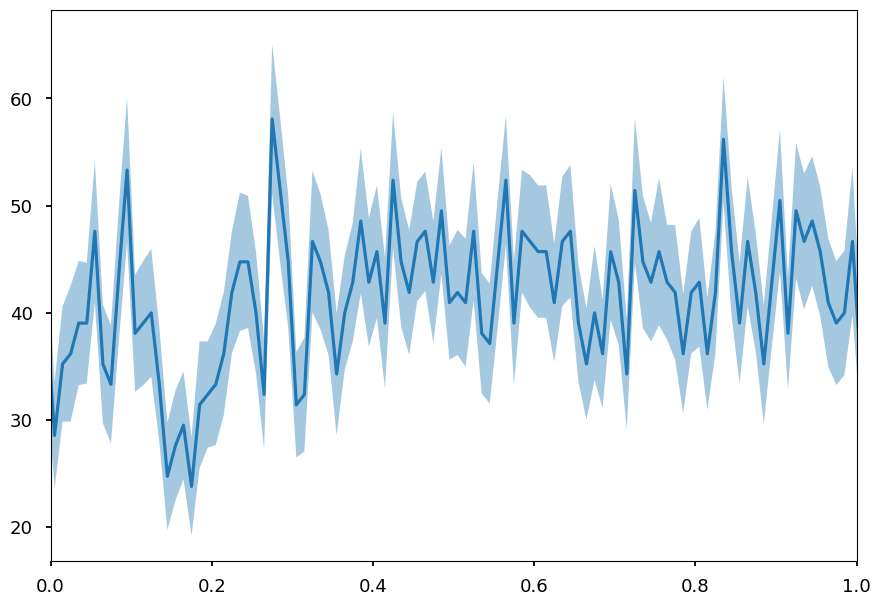

In [146]:
_ = plt.plot(ts[0], psth)
_ = plt.fill_between(ts[0], psth + sem, psth - sem, alpha=0.4)
plt.xlim(0, 1)

In [36]:
 psth_foraging.UnitTrialAlignedSpikes().heading

# 
subject_id           : int                          # institution 6 digit animal ID
session              : smallint                     # session number
insertion_number     : int                          # 
clustering_method    : varchar(16)                  # 
unit                 : smallint                     # 
align_type_name      : varchar(32)                  # user-friendly name of alignment type
trial                : smallint                     # trial number (1-based indexing)
---
aligned_spikes       : longblob                     # 

In [ ]:
psth_foraging.UnitTrialAlignedSpikes.aggr(ephys.Unit.proj() * histology.ElectrodeCCFPosition.ElectrodePosition, hemi='IF(ccf_x > 5739, "left", "right")')

In [ ]:
psth_foraging.TrialCondition.get_trials(f'{ipsi}_hit{no_early_lick}', offset) & key

In [13]:
a[0]['trial'].shape

(26363,)

## Drifting metrics

### Get mean firing rate across trials (aligned to ITI start); grouped by trial type

In [49]:
key={'subject_id': 473361, 'session': 47, 'insertion_number': 1, 'clustering_method': 'kilosort2', 'unit': 541}

In [14]:
all_spikes = (psth_foraging.UnitTrialAlignedSpikes & key & 'align_type_name = "iti_start"').fetch('aligned_spikes')
win = (psth_foraging.AlignType & 'align_type_name = "iti_start"').fetch1('psth_win')

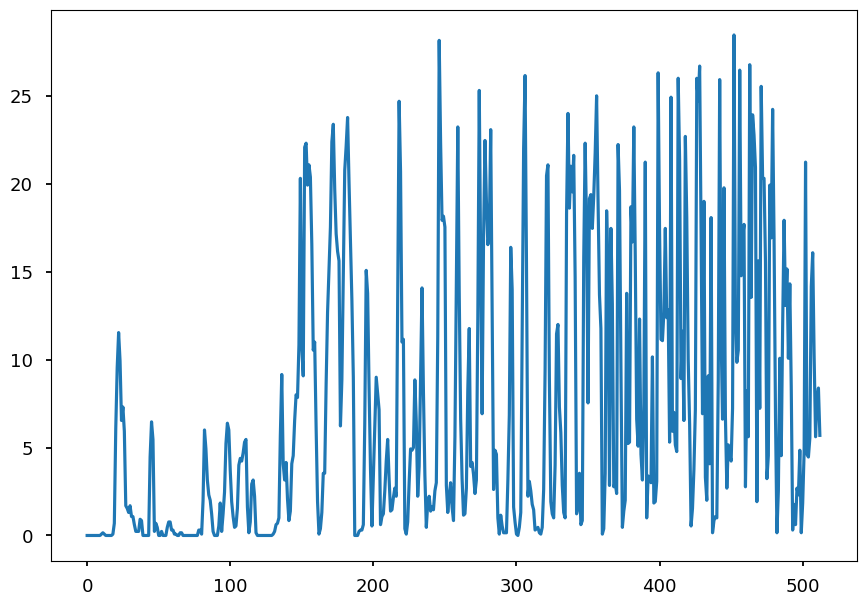

In [131]:
aver_firing_per_trial = list(map(lambda x: len(x) / (win[1] - win[0]), all_spikes))  # Average firing rate
plt.plot(aver_firing_per_trial)

In [16]:
from scipy.stats import kstest
from scipy.stats import poisson

In [9]:
key={'subject_id': 473361, 'session': 47, 'insertion_number': 1, 'clustering_method': 'kilosort2', 'unit': 541}

keys = (ephys.Unit & psth_foraging.UnitPSTHChoiceOutcome).fetch('KEY')

In [10]:
key = np.random.choice(keys, 1)

Dave's drift metric, grouped by choice x outcome: 0.0
not grouped: 0.0


Text(0.5, 0.98, "[{'subject_id': 473360, 'session': 50, 'insertion_number': 1, 'clustering_method': 'kilosort2', 'unit': 641}]")

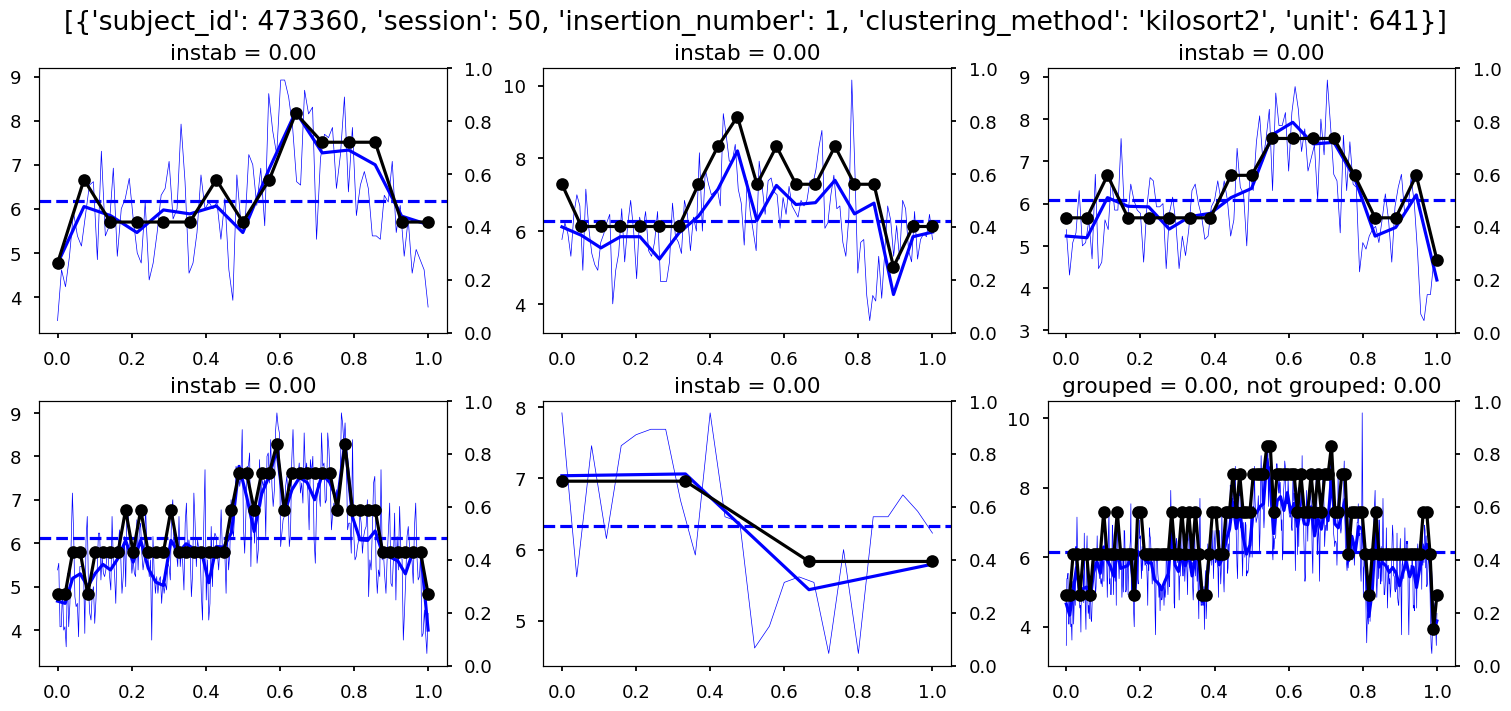

In [20]:
unique_cond = dj.U('choice', 'outcome') & (psth_foraging.UnitPSTHChoiceOutcome & key)
fig, ax = plt.subplots(2, 3, figsize=(15, 7), layout='constrained')
ax = ax.flatten()

poisson_cdf_all = []

for n, q in enumerate(unique_cond.fetch('KEY')):
    this_raw = (psth_foraging.UnitPSTHChoiceOutcome & key & q & 'align_type_name = "iti_start"').fetch1('raw')
    poisson_cdf, instability = compute_and_plot_drift_metric(this_raw, 
                                                             6,
                                                             # int(np.round(len(this_raw)/20)), 
                                                             ax[n])
    ax[n].set_title(f'instab = {instability:.2f}')
    
    poisson_cdf_all.append(poisson_cdf)
    
poisson_cdf_all = np.hstack(poisson_cdf_all)
instability_all = np.logical_or(poisson_cdf_all > 0.95, poisson_cdf_all < 0.05).sum() / len(poisson_cdf_all)
print(f"Dave's drift metric, grouped by choice x outcome: {instability_all}")
    
# Not grouped
this_raw = (psth_foraging.UnitTrialAlignedSpikes & key & 'align_type_name = "iti_start"').fetch('aligned_spikes', order_by='trial')
poisson_cdf, instability = compute_and_plot_drift_metric(this_raw,
                                                         6,
                                                         # int(np.round(len(this_raw)/20)), 
                                                         ax[-1])
ax[-1].set_title(f'grouped = {instability_all:.2f}, not grouped: {instability:.2f}')
print(f"not grouped: {instability}")
fig.suptitle(key)

In [12]:
def compute_poisson_p(aver_firing_per_trial, window_size=6, ds_factor=6):
    """
    Dave Liu's method
    Major problem: the result highly depends on the window size
    """
    mean_spike_rate = np.mean(aver_firing_per_trial)
    # -- moving-average
    kernel = np.ones(window_size) / window_size
    processed_trial_spike_rates = np.convolve(aver_firing_per_trial, kernel, 'valid')
    # -- down-sample
    processed_trial_spike_rates = processed_trial_spike_rates[::ds_factor]
    # -- compute drift_qc from poisson distribution
    poisson_cdf = poisson.cdf(processed_trial_spike_rates, mean_spike_rate)
    instability = np.logical_or(poisson_cdf > 0.95, poisson_cdf < 0.05).sum() / len(poisson_cdf)
    return np.array(poisson_cdf), instability, processed_trial_spike_rates

def compute_and_plot_drift_metric(this_raw, win_size, ax):
    this_aver = list(map(lambda x: len(x) / (win[1] - win[0]), this_raw))
    ax.plot(np.linspace(0, 1, len(this_aver)), np.array(this_aver), 'b', lw=0.5)
    
    poisson_cdf, instability, smoothed_firing = compute_poisson_p(this_aver, window_size=win_size, 
                                                 ds_factor=win_size)
    # p = kstest(this_aver, 'norm')
    # print(p.pvalue)
    xx = np.linspace(0, 1, len(poisson_cdf))    
    ax.plot(xx, smoothed_firing, 'b-')
    ax.axhline(np.mean(this_aver), c='b', ls='--')

    idx_sig = np.logical_or(poisson_cdf > 0.95, poisson_cdf < 0.05)
    ax2 = ax.twinx()
    ax2.plot(xx, poisson_cdf, 'ko-')
    ax2.plot(xx[idx_sig], poisson_cdf[idx_sig], 'ro')
    ax2.set_ylim([0, 1])
    
    return poisson_cdf, instability


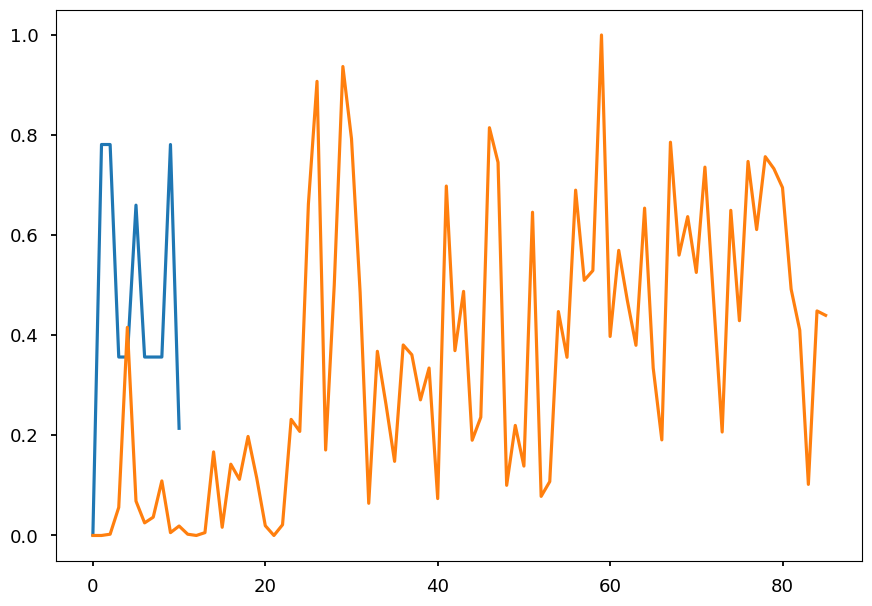

In [190]:
plt.plot(poisson_cdf)
plt.plot(processed_trial_spike_rates / max(processed_trial_spike_rates))

In [91]:
instability

0.5465116279069767

In [77]:
this_aver_firing.shape

(92,)

In [329]:
key

(473361, 47, 1, 'kilosort2', 73, 0.709302)

In [328]:
key = (ephys.MAPClusterMetric.DriftMetric & psth_foraging.UnitPSTHChoiceOutcome).fetch(limit=1, offset=10)[0]

### Try add time to linear fitting

In [ ]:
    
    # -- Fetech data --
    period, behavior_model = key['period'], key['behavior_model']

    # Parse behavioral model_id
    if behavior_model.isnumeric():
        model_id = int(behavior_model)
    else:
        model_id = (foraging_model.FittedSessionModelComparison.BestModel &
                    key & 'model_comparison_idx=0').fetch1(behavior_model)

    # Parse independent variable
    independent_variables = (LinearModel.X & key).fetch('var_name')
    if_intercept = (LinearModel & key).fetch1('if_intercept')

    # Get data
    #  period_activity = compute_unit_period_activity(key, period)
    period_activity = (UnitPeriodActivity & key & {'period': period}).fetch1('trial', 'firing_rates')

    all_iv = _get_unit_independent_variable(key, model_id=model_id)

    # TODO Align ephys event with behavior using bitcode! (and save raw bitcodes)
    trial = all_iv.trial  # Without ignored trials
    trial_with_ephys = trial <= max(period_activity[0])
    trial = trial[trial_with_ephys]  # Truncate behavior trial to max ephys length (this assumes the first trial is aligned, see ingest.ephys)
    all_iv = all_iv[trial_with_ephys]  # Also truncate all ivs
    firing = period_activity[1][trial - 1]  # Align ephys trial and model trial (e.g., no ignored trials in model fitting)

    # -- Fit --
    y = pd.DataFrame({f'{period} firing': firing})
    x = all_iv[independent_variables].astype(float)
    try:
        model = sm.OLS(y, sm.add_constant(x) if if_intercept else x)
        model_fit = model.fit()


## Reaction time

In [4]:
from pipeline import foraging_analysis
from pipeline.util import _get_session_independent_variable
import seaborn as sns
from scipy.stats import pearsonr

In [33]:
df.trial

0          1
1          2
2          3
3          4
4          5
        ... 
1135    1138
1136    1139
1137    1140
1138    1141
1139    1142
Name: trial, Length: 1140, dtype: int64

(0.0, 1.0)

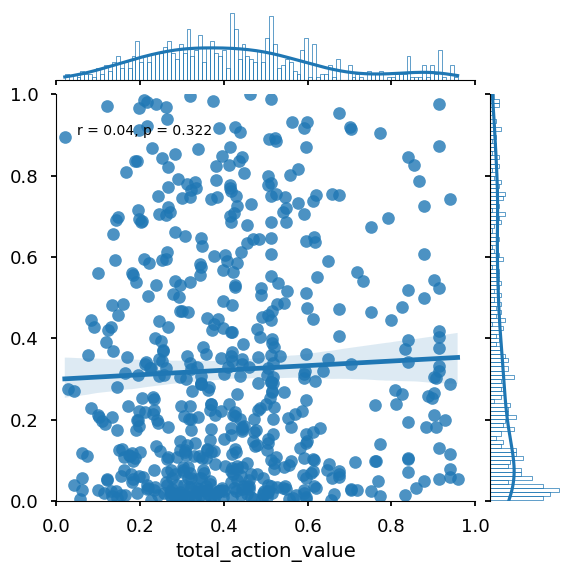

In [8]:
key = {'subject_id': 473360, 'session': 39}
rts = (foraging_analysis.TrialStats & key).fetch('reaction_time')

#  _ = plt.hist(rts, np.arange(0, 1, 0.005))
_, df = _get_session_independent_variable(key, model_id=14)

rt = rts[df.trial - 1].astype(float) 
sumQ = df.total_action_value.astype(float)
cutoff = 1
small_rt = rt[rt < cutoff]
x=sumQ[rt < cutoff]
y=small_rt

h = sns.jointplot(x=x, y=y, kind='reg',
             marginal_kws=dict(bins=100, fill=False))

r, p = pearsonr(x, y)
h.ax_joint.annotate(f'r = {r:.2f}, p = {p:.3f}', fontsize=10, xy=(0.05, 0.9), xycoords='axes fraction')

# plt.plot(df.total_action_value, rts[df.trial], 'o')
plt.xlim([0, 1])
plt.ylim([0, cutoff])

## For each session

### Directly export to pkl on AWS instead of messing up with DJ tables

In [3]:
from dataclasses import dataclass

@dataclass
class SessionSpikeTimeAligned:
    sess_key: dict
    unit_keys: list = None
    align_tos: List[str] = None
    trials: dict = None
    times: dict = None  # Bin center
    aligned_firings: dict = None # unit * trial * time
    
@dataclass
class SessionData:
    session_key: dict
    aligned_firing: SessionAlignedFiring


In [4]:
def align_spikes_to_event(spike_time_units, event_times, win):
    """
    Parameters
    -------------
    spike_time_units: list(units)[ndarray(spike times)]
    event_times: dict[align_type: ndarray(event time)]
    win: cut off window, list[start, end]
    
    Returns
    -------------
    spike_time_aligned: dict[align_type: list(unit)[ndarray(trial, aligned_time)]]
    """
    
    for align_type, event_time in event_times.items():
        for spikes in spike_times_units:
            spike_time_aligned = []
            for e_t in event_time:
                s_t = spikes[(e_t + win[0] <= spikes) & (spikes < e_t + win[1])]
                spike_time_aligned.append(s_t - e_t)
        
    

def session_align_spike_counts(sess_key, align_types=['go_cue'], bin_size=0.02) -> SessionAlignedFiring:
    """
    return: spike_count_aligned [unit_qced, trial, time bins]
    """

    q_unit_qc_session = ephys.UnitForagingQC & sess_key & 'unit_minimal_session_qc'
    units = q_unit_qc_session.fetch('KEY')   
    spike_times_units = (ephys.Unit & q_unit_qc_session).fetch('spike_times')
    
    trials, time_bins, aligned_firings = {}, {}, {}
    
    for align_type in align_types:
        q_align_type = psth_foraging.AlignType & {'align_type_name': align_type}

        # -- Get global times for spike and event --
        q_event = ephys.TrialEvent & sess_key & q_align_type   # Using ephys.TrialEvent, not experiment.TrialEvent

        # Session-wise event times (relative to session start)
        events, trial_num = q_event.fetch('trial_event_time', 'trial', order_by='trial asc')
        # Make event times also relative to the first sTrig
        events -= ((ephys.TrialEvent & sess_key) & {'trial_event_type': 'bitcodestart', 'trial': 1}).fetch1('trial_event_time')
        events = events.astype(float)

        # Manual correction if necessary (e.g. estimate trialstart from bitcodestart when zaberready is missing)
        events += q_align_type.fetch('time_offset').astype(float)

        # -- Align spike times to each event --
        win = q_align_type.fetch1('psth_win')
        bins = np.arange(win[0], win[1], bin_size)

        # --- Aligned spike count in bins ---
        spike_count_aligned = np.empty([len(units), len(trial_num), len(bins) - 1], dtype='uint8')

        for n, spikes in enumerate(spike_times_units):
            spike_time_aligned = []
            for e_t in events:
                s_t = spikes[(e_t + win[0] <= spikes) & (spikes < e_t + win[1])]
                spike_time_aligned.append(s_t - e_t)
            spike_count_aligned[n, :, :] = np.array(list(map(lambda x: np.histogram(x, bins=bins)[0], spikes_aligned)))
            
        # --- Save data ---
        trials[align_type] = trial_num
        time_bins[align_type] = np.mean([bins[:-1], bins[1:]], axis=0)
        aligned_firings[align_type] = spike_count_aligned

    aligned_firing = SessionAlignedFiring(sess_key=sess_key, unit_keys=units, trials=trials, 
                                          times=time_bins, align_tos=align_types, aligned_firings=aligned_firings)
    aligned_firing.bin_size = bin_size
    
    return aligned_firing

In [ ]:
def smooth_firing(aligned_firing: SessionAlignedFiring, 

In [ ]:
UnitPeriodActivity

Export to disk

In [5]:
def export_one_session(sess, align_types, bin_size):
    dj.conn().connect()
    session_aligned = session_align_spike_counts(sess, align_types=align_types, bin_size=bin_size)
    fname = f'{sess["subject_id"]}_{sess["session"]}_aligned_spike_counts'    
    dill.dump(session_aligned, open('/home/jupyter/s3-drive/export/' + f'{fname}.pkl', 'wb'))
    del session_aligned
    print(f'{sess} done')

In [6]:
import multiprocessing as mp
pool = mp.Pool(4)

{'subject_id': 473360, 'session': 51} done
{'subject_id': 473361, 'session': 47} done
{'subject_id': 473360, 'session': 49} done
{'subject_id': 473360, 'session': 52} done
{'subject_id': 473360, 'session': 50} done
{'subject_id': 473361, 'session': 59} done
{'subject_id': 473361, 'session': 57} done
{'subject_id': 473361, 'session': 60} done
{'subject_id': 482353, 'session': 37} done
{'subject_id': 482353, 'session': 33} done
{'subject_id': 482353, 'session': 34} done
{'subject_id': 482353, 'session': 36} done
{'subject_id': 482353, 'session': 45} done
{'subject_id': 482353, 'session': 43} done
{'subject_id': 494691, 'session': 17} done
{'subject_id': 494691, 'session': 18} done
{'subject_id': 482353, 'session': 42} done


In [13]:
psth_foraging.UnitPeriodActivity()

subject_id institution 6 digit animal ID,session session number,insertion_number,clustering_method,unit,period,trial Actual trials,spike_counts,durations,firing_rates
473360,49,1,kilosort2,0,before_2,=BLOB=,=BLOB=,=BLOB=,=BLOB=
473360,49,1,kilosort2,1,before_2,=BLOB=,=BLOB=,=BLOB=,=BLOB=
473360,49,1,kilosort2,2,before_2,=BLOB=,=BLOB=,=BLOB=,=BLOB=
473360,49,1,kilosort2,3,before_2,=BLOB=,=BLOB=,=BLOB=,=BLOB=
473360,49,1,kilosort2,4,before_2,=BLOB=,=BLOB=,=BLOB=,=BLOB=
473360,49,1,kilosort2,5,before_2,=BLOB=,=BLOB=,=BLOB=,=BLOB=
473360,49,1,kilosort2,6,before_2,=BLOB=,=BLOB=,=BLOB=,=BLOB=
473360,49,1,kilosort2,7,before_2,=BLOB=,=BLOB=,=BLOB=,=BLOB=
473360,49,1,kilosort2,8,before_2,=BLOB=,=BLOB=,=BLOB=,=BLOB=
473360,49,1,kilosort2,9,before_2,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [ ]:
session_to_export = (dj.U('subject_id', 'session')
                     & (ephys.UnitForagingQC & 'unit_minimal_session_qc = 1') 
                     & histology.ElectrodeCCFPosition.ElectrodePosition    # With ccf
                     - experiment.PhotostimForagingTrial                   # No photostim
                     ).fetch('KEY')

align_types = ['go_cue', 'choice', 'iti_start']
bin_size = 0.01

results = [pool.apply_async(export_one_session, args=(sess, align_types, bin_size)) for sess in session_to_export]
_ = [r.get() for r in results]

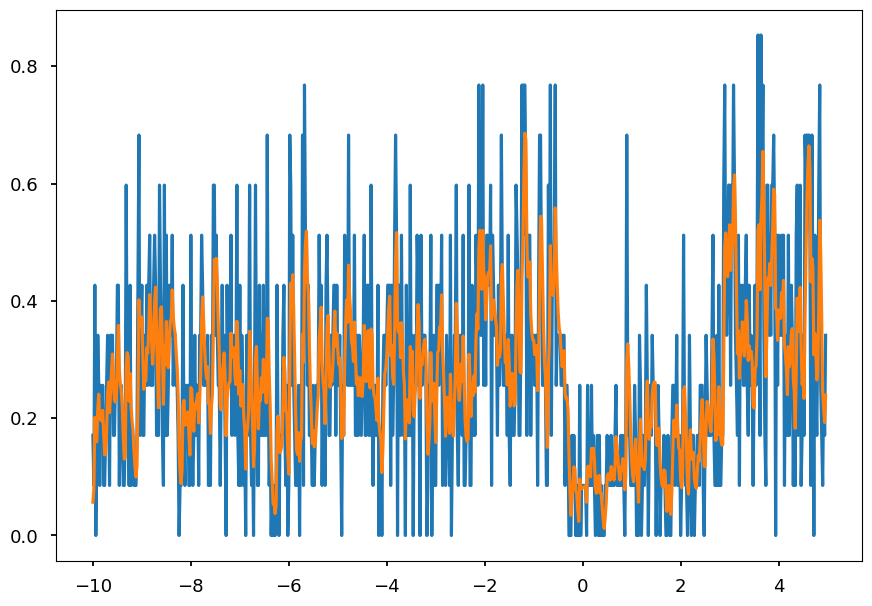

In [107]:
_=plt.plot(session_aligned.time_bins['choice'][:-1], np.mean(session_aligned.aligned_firings['choice'][100,:,:]/0.02, axis=0))
_=plt.plot(session_aligned.time_bins['choice'][:-1], np.mean(tmp[100,:,:], axis=0)/0.02)

In [10]:
load = dill.load(open('/home/jupyter/s3-drive/export/' + '494691_18_aligned_spike_counts.pkl', 'rb'))

In [24]:
s = scipy.sparse.csr_matrix(load.aligned_firings['choice'])

TypeError: expected dimension <= 2 array or matrix

In [26]:
psth_foraging.AlignType()

align_type_name user-friendly name of alignment type,trial_event_type,align_type_description description of this align type,"trial_offset e.g., offset = 1 means the psth will be aligned to the event of the *next* trial.","time_offset will be added to the event time for manual correction (e.g., bitcodestart to actual zaberready)","psth_win [t_min, t_max], time window by which `compute_unit_psth_and_raster` counts spikes","xlim [x_min, x_max], default xlim for plotting PSTH (could be overridden during plotting)"
choice,choice,first non-early lick,0,0.00000,=BLOB=,=BLOB=
first_lick_after_go_cue,choice,first non-early lick,0,0.00000,=BLOB=,=BLOB=
go_cue,go,,0,0.00000,=BLOB=,=BLOB=
iti_start,trialend,,0,0.00000,=BLOB=,=BLOB=
next_trial_start,zaberready,,1,0.00000,=BLOB=,=BLOB=
next_trial_start_bitcode,bitcodestart,estimate actual trial start by bitcodestart + 146 ms,1,0.14600,=BLOB=,=BLOB=
next_two_trial_start,zaberready,,2,0.00000,=BLOB=,=BLOB=
next_two_trial_start_bitcode,bitcodestart,,2,0.14600,=BLOB=,=BLOB=
trial_start,zaberready,,0,0.00000,=BLOB=,=BLOB=
trial_start_bitcode,bitcodestart,estimate actual trial start by bitcodestart + 146 ms,0,0.14600,=BLOB=,=BLOB=


# Export behavioral

In [3]:
session_key = session_keys[-1]

In [9]:
from pipeline.util import _get_session_independent_variable

def get_df_session_behavior(session_key):

    q_trial = experiment.SessionTrial * experiment.BehaviorTrial & session_key 
    q_trial *= experiment.WaterPortChoice.proj(choice='water_port')  # Add choice

    # reward schedule
    q_p_reward = experiment.BehaviorTrial.proj() * experiment.SessionBlock.BlockTrial * experiment.SessionBlock.WaterPortRewardProbability & session_key
    p_reward = np.vstack([(q_p_reward & 'water_port="left"').fetch('reward_probability', order_by='trial').astype(float),
                          (q_p_reward & 'water_port="right"').fetch('reward_probability', order_by='trial').astype(float)])

    model_id = 20  # Hard-coded model_id (Hattori with choice kernel)

    _, df_latent = _get_session_independent_variable(session_key, model_id=model_id)

    # Add all trials, including ignored
    df_q_trial = pd.DataFrame(q_trial.fetch())[['subject_id', 'session', 'trial', 'early_lick', 'choice']]
    df = df_q_trial.merge(df_latent, on=('subject_id', 'session', 'trial'), how='left')

    # Add p_reward
    df['left_reward_prob'], df['right_reward_prob'] = p_reward
    
    return df

Export to S3

In [13]:
def export_one_session_behavior(sess):
    dj.conn().connect()
    session_behavior = get_df_session_behavior(sess)
    fname = f'{sess["subject_id"]}_{sess["session"]}_behavior'    
    dill.dump(session_behavior, open('/home/jupyter/s3-drive/export/' + f'{fname}.pkl', 'wb'))
    del session_behavior
    print(f'{sess} done')

In [14]:
import multiprocessing as mp
pool = mp.Pool(4)

session_to_export = (dj.U('subject_id', 'session')
                     & (ephys.UnitForagingQC & 'unit_minimal_session_qc = 1') 
                     & histology.ElectrodeCCFPosition.ElectrodePosition    # With ccf
                     - experiment.PhotostimForagingTrial                   # No photostim
                     ).fetch('KEY')

results = [pool.apply_async(export_one_session_behavior, args=(sess,)) for sess in session_to_export]
_ = [r.get() for r in results]

{'subject_id': 473360, 'session': 50} done
{'subject_id': 473360, 'session': 51} done
{'subject_id': 473360, 'session': 52} done
{'subject_id': 473360, 'session': 49} done
{'subject_id': 473361, 'session': 47} done
{'subject_id': 473361, 'session': 57} done
{'subject_id': 473361, 'session': 59} done
{'subject_id': 473361, 'session': 60} done
{'subject_id': 482353, 'session': 33} done
{'subject_id': 482353, 'session': 34} done
{'subject_id': 482353, 'session': 36} done
{'subject_id': 482353, 'session': 37} done
{'subject_id': 482353, 'session': 42} done
{'subject_id': 482353, 'session': 43} done
{'subject_id': 482353, 'session': 45} done
{'subject_id': 494691, 'session': 17} done
{'subject_id': 494691, 'session': 18} done


# Generate z-scores tuning across deltaQ, sumQ, rpe, etc.

## Sort by different quatiles of latent variable, generate z-score firing for each unit

In [3]:
session_key = session_keys[-2]

In [4]:
df_aligned_spikes = dill.load(open(cache_folder + f'{session_key["subject_id"]}_{session_key["session"]}_aligned_spike_counts.pkl', 'rb'))
df_behavior = dill.load(open(cache_folder + f'{session_key["subject_id"]}_{session_key["session"]}_behavior.pkl', 'rb'))

In [5]:
df_behavior.keys()

Index(['subject_id', 'session', 'trial', 'early_lick', 'choice_x', 'model_id',
       'left_', 'right_', 'left_action_value', 'right_action_value',
       'left_choice_prob', 'right_choice_prob', 'left_choice_kernel',
       'right_choice_kernel', 'relative_action_value_lr', 'total_action_value',
       'choice_y', 'choice_lr', 'outcome', 'reward', 'rpe', 'left_reward_prob',
       'right_reward_prob'],
      dtype='object')

In [10]:
def compute_unit_firing_binned_by_latent_variable(df_aligned_spikes,
                                                  df_behavior,
                                                  align_to='iti_start',
                                                  time_win = [0, 2],
                                                  latent_name='relative_action_value_lr',
                                                  latent_variable_offset=0,   # <=0. e.g., -1 means use the latent variable from trial-1
                                                  latent_bins=None,                                                  
                                                  if_z_score_latent=True,
                                                  ):
    '''
    df_aligned_spikes --> df_unit_latent_bin_firing (raw)
    '''
    
    aligned_spikes = df_aligned_spikes.aligned_firings[align_to]
    ts = df_aligned_spikes.times[align_to]

    valid_trials = df_aligned_spikes.trials[align_to]  # may skip ignored trials
    latent_values = df_behavior.query('trial in @valid_trials')[latent_name]
    
    # offset latent variable
    assert latent_variable_offset <= 0, 'invalid latent_variable_offset'
    latent_values = latent_values.iloc[:len(latent_values)+latent_variable_offset]
    aligned_spikes = aligned_spikes[:, -latent_variable_offset:, :]
 
    # z-score latent variable
    if if_z_score_latent:
        latent_values = scipy.stats.zscore(latent_values.astype(float), nan_policy='omit')
        
    # determine bins for latent variable
    if latent_bins is None:
        latent_bins = np.linspace(-3, 3, 20) if if_z_score_latent else np.linspace(np.min(latent_values), np.max(latent_values), 20)      
    latent_bin_centers = (latent_bins[:-1] + latent_bins[1:]) / 2
    
    # compute average firing rate in the given time window (N_neurons * N_trials)
    aligned_aver_firing = np.mean(aligned_spikes[:, :, (time_win[0] <= ts) & (ts < time_win[1])], axis=2) / df_aligned_spikes.bin_size  # spike / s

    # sort firing according to bins of latent variable (N_bins list of N_neurons * N_trials in the bin)
    latent_binned_firing = [aligned_aver_firing[:, (low <= latent_values) & (latent_values < high)] 
                           for low, high in zip(latent_bins[:-1], latent_bins[1:])]

    # for each unit, mean and sem across selected trials (N_neurons * N_bins)
    df_mean = pd.DataFrame(np.array(list(map(lambda x: np.mean(x, axis=1), latent_binned_firing))).T, 
                             index=pd.MultiIndex.from_frame(pd.DataFrame(df_aligned_spikes.unit_keys)), 
                             columns=pd.MultiIndex.from_tuples([('mean', center) for center in latent_bin_centers], names=['stats', f"{latent_name}{'_z_score' if if_z_score_latent else ''}"]),
                             )
    df_sem = pd.DataFrame(np.array(list(map(lambda x: scipy.stats.sem(x, axis=1), latent_binned_firing))).T,
                             index=pd.MultiIndex.from_frame(pd.DataFrame(df_aligned_spikes.unit_keys)), 
                             columns=pd.MultiIndex.from_tuples([('sem', center) for center in latent_bin_centers], names=['stats', f"{latent_name}{'_z_score' if if_z_score_latent else ''}"]),
                             )
    df_unit_latent_bin_firing = pd.concat([df_mean, df_sem], axis=1)

    # for each unit, compute pearson r and p
    pearson_r_p = [scipy.stats.pearsonr(x[~np.isnan(x)], latent_bins[:-1][~np.isnan(x)])
                   if np.sum(~np.isnan(x)) >= 2
                   else (np.nan, np.nan) 
                   for x in np.array(df_mean)]
    pearson_r, pearson_p = zip(*pearson_r_p)
    df_unit_latent_bin_firing['r'] = pearson_r
    df_unit_latent_bin_firing['p'] = pearson_p
    
    # compute z_score mean and std using average psth aligned to go_cue (spike / s)
    aver_psth = np.mean(df_aligned_spikes.aligned_firings['go_cue'], axis=1) / df_aligned_spikes.bin_size
    z_mean = np.mean(aver_psth, axis=1)
    z_std = np.std(aver_psth, axis=1)
    df_unit_latent_bin_firing['z_mean'] = z_mean
    df_unit_latent_bin_firing['z_std'] = z_std
    
    # store meta info
    df_unit_latent_bin_firing._metadata = dict(align_to=align_to, time_win=time_win, latent_name=latent_name, 
                                          latent_variable_offset=latent_variable_offset, if_z_score_latent=if_z_score_latent)
    
    return df_unit_latent_bin_firing


def compute_group_tuning(df_unit_latent_bin_firing, 
                         unit_keys=None,
                         if_z_score_firing=True,   # z-score
                         significance_level=None,  # if None, all cells
                         if_flip_tuning=True # auto flip here, within the selected unit_keys, where users controls significance etc.
                         ):
    
    if unit_keys is None:
        unit_keys = df_unit_latent_bin_firing.index
        
    if significance_level is not None:
        unit_keys = unit_keys[df.loc[unit_keys].p < significance_level]
    
    selected_tuning = df_unit_latent_bin_firing.loc[unit_keys, 'mean']
    z_mean = df_unit_latent_bin_firing.loc[unit_keys, 'z_mean']
    z_std = df_unit_latent_bin_firing.loc[unit_keys, 'z_std']
    
    if if_z_score_firing:
        #  selected_tuning = selected_tuning.apply(scipy.stats.zscore, axis=1, nan_policy='omit')  # using mean and binned activity (not full dynamic range of the neuron!)
        selected_tuning = selected_tuning.sub(z_mean, axis=0).div(z_std, axis=0)       # using dynamic range of the neuron (average psth aligned to go_cue)
        
    if if_flip_tuning:
        to_flip = df_unit_latent_bin_firing['r'] < 0
        selected_tuning.loc[to_flip] = np.array(selected_tuning.loc[to_flip])[:, ::-1]

    tuning_mean = selected_tuning.mean(axis=0)
    tuning_sem = selected_tuning.sem(axis=0)      
    
    return tuning_mean, tuning_sem, selected_tuning


def plot_population_tuning(tuning_mean, tuning_sem, selected_tuning, **kwargs):
    plt.subplots(1, 1)
    plt.errorbar(tuning_mean.index, tuning_mean, tuning_sem, lw=2, capsize=5, elinewidth=2, markeredgewidth=2)
    # plt.plot(tuning_mean.index, selected_tuning.T, c='gray', ls='-', alpha=0.1)
    plt.title(f'n = {selected_tuning.shape[0]}, {[kwargs[x] for x in ["latent_name", "align_to", "time_win"]]}')

   

## Compute z-score for all units * z-score settings

In [8]:
z_tuning_mappper = {'dQ_go_cue_before_2': dict(align_to='go_cue', time_win=[-2, 0], latent_name='relative_action_value_lr', latent_bins=np.linspace(-3, 3, 20), if_z_score_latent=True, latent_variable_offset=-1),
                    'dQ_iti_start_before_1': dict(align_to='iti_start', time_win=[-1, 0], latent_name='relative_action_value_lr', latent_bins=np.linspace(-3, 3, 20), if_z_score_latent=True),
                    'dQ_iti_start_after_2': dict(align_to='iti_start', time_win=[0, 2], latent_name='relative_action_value_lr', latent_bins=np.linspace(-3, 3, 20), if_z_score_latent=True),
                    
                    'sumQ_go_cue_before_2': dict(align_to='go_cue', time_win=[-2, 0], latent_name='total_action_value', latent_bins=np.linspace(-3, 3, 20), if_z_score_latent=True, latent_variable_offset=-1),
                    'sumQ_iti_start_before_1': dict(align_to='iti_start', time_win=[-1, 0], latent_name='total_action_value', latent_bins=np.linspace(-3, 3, 20), if_z_score_latent=True),
                    'sumQ_iti_start_after_2': dict(align_to='iti_start', time_win=[0, 2], latent_name='total_action_value', latent_bins=np.linspace(-3, 3, 20), if_z_score_latent=True),
                    
                    'rpe_go_cue_before_2': dict(align_to='go_cue', time_win=[-2, 0], latent_name='rpe', latent_bins=np.linspace(-1, 1, 20), if_z_score_latent=False, latent_variable_offset=-1),
                    'rpe_choice_after_2': dict(align_to='choice', time_win=[0, 2], latent_name='rpe', latent_bins=np.linspace(-1, 1, 20), if_z_score_latent=False),                    
                    'rpe_iti_start_before_1': dict(align_to='iti_start', time_win=[-1, 0], latent_name='rpe', latent_bins=np.linspace(-1, 1, 20), if_z_score_latent=False),
                    'rpe_iti_start_after_2': dict(align_to='iti_start', time_win=[0, 2], latent_name='rpe', latent_bins=np.linspace(-1, 1, 20), if_z_score_latent=False),
                   }

In [17]:
def compute_one_session_z_score(session_key):
    df_aligned_spikes = dill.load(open(cache_folder + f'{session_key["subject_id"]}_{session_key["session"]}_aligned_spike_counts.pkl', 'rb'))
    df_behavior = dill.load(open(cache_folder + f'{session_key["subject_id"]}_{session_key["session"]}_behavior.pkl', 'rb'))
    
    this_session = {}
    for name, setting in z_tuning_mappper.items():
        # print(name)
        this_session[name] = compute_unit_firing_binned_by_latent_variable(df_aligned_spikes, df_behavior, **setting)
    
    print(f'{session_key} done')
    return this_session

In [16]:
results = [pool.apply_async(compute_one_session_z_score, args=(sess,)) for sess in session_keys]
all_session = [r.get() for r in results]

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:252: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid val

In [27]:
all_session[0].keys()

dict_keys(['dQ_go_cue_before_2', 'dQ_iti_start_before_1', 'dQ_iti_start_after_2', 'sumQ_go_cue_before_2', 'sumQ_iti_start_before_1', 'sumQ_iti_start_after_2', 'rpe_go_cue_before_2', 'rpe_choice_after_2', 'rpe_iti_start_before_1', 'rpe_iti_start_after_2'])

### Export all z-score to pickle

In [42]:
for this_setting_name in z_tuning_mappper:
    dfs_for_this_setting = []
    for dfs_this_session in all_session:
        dfs_for_this_setting.append(dfs_this_session[this_setting_name])
        
    df_this_setting_all_session = pd.concat(dfs_for_this_setting)
    df_this_setting_all_session._metadata = dfs_this_session[this_setting_name]._metadata
    fname = f'z_score_all_{this_setting_name}.pkl'
    df_this_setting_all_session.to_pickle(cache_folder + fname)

In [43]:
df_this_setting_all_session._metadata

{'align_to': 'iti_start',
 'time_win': [0, 2],
 'latent_name': 'rpe',
 'latent_variable_offset': 0,
 'if_z_score_latent': False}

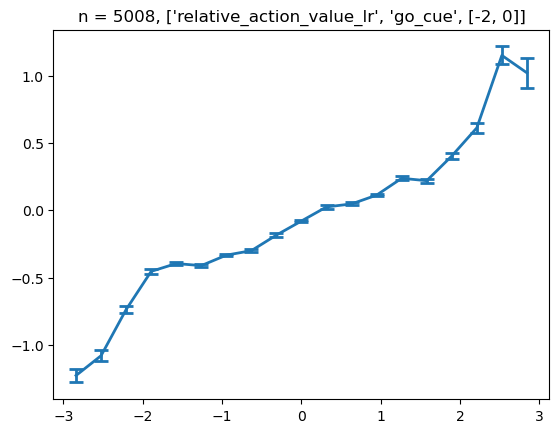

In [44]:
df_this_setting_all_session = pd.read_pickle(cache_folder + 'z_score_all_dQ_go_cue_before_2.pkl')
plot_population_tuning(*compute_group_tuning(df_this_setting_all_session, 
                                                unit_keys=None, #df.index[df.r > 0], 
                                                if_z_score_firing=True,
                                                significance_level=None,
                                                if_flip_tuning=False if df_this_setting_all_session._metadata['latent_name'] == 'rpe' else True), **df_this_setting_all_session._metadata)

dQ_go_cue_before_2
dQ_iti_start_before_1
dQ_iti_start_after_2
sumQ_go_cue_before_2
sumQ_iti_start_before_1
sumQ_iti_start_after_2
rpe_go_cue_before_2
rpe_choice_after_2
rpe_iti_start_before_1
rpe_iti_start_after_2


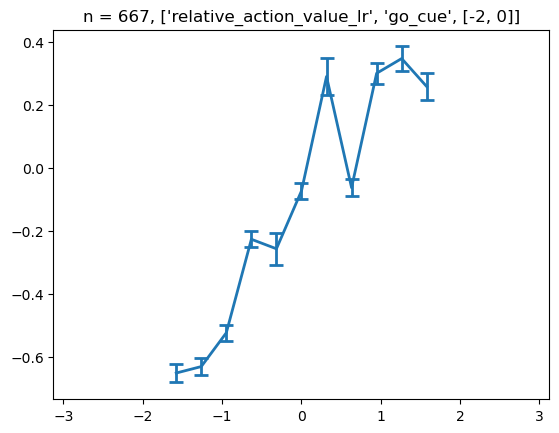

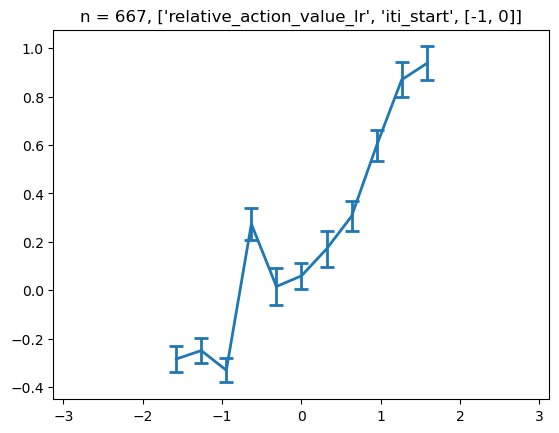

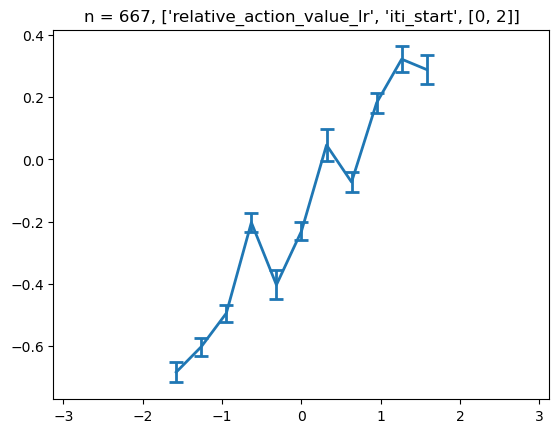

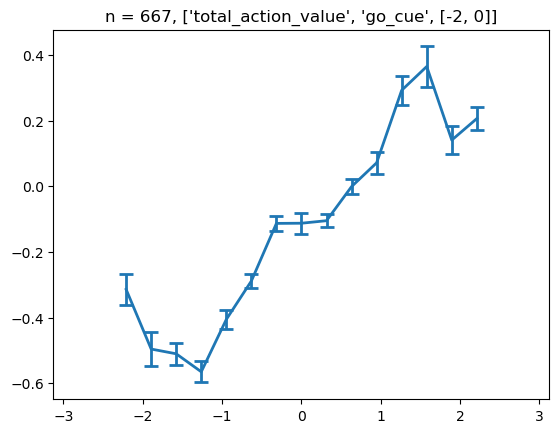

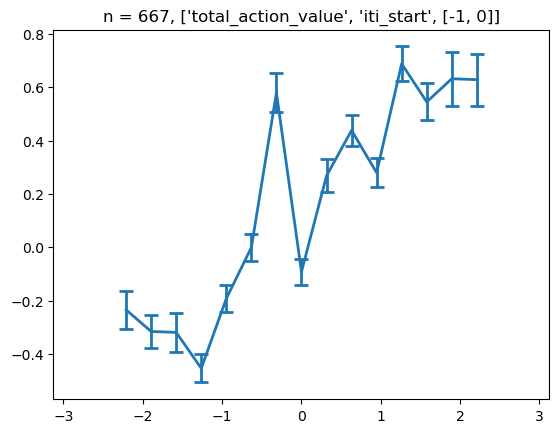

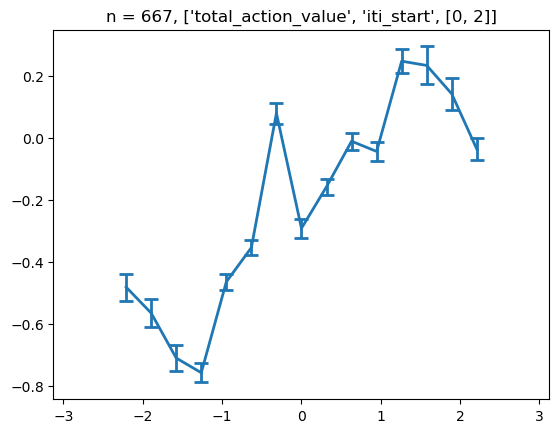

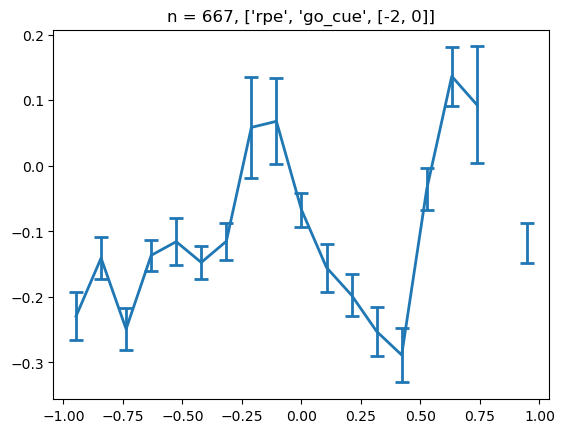

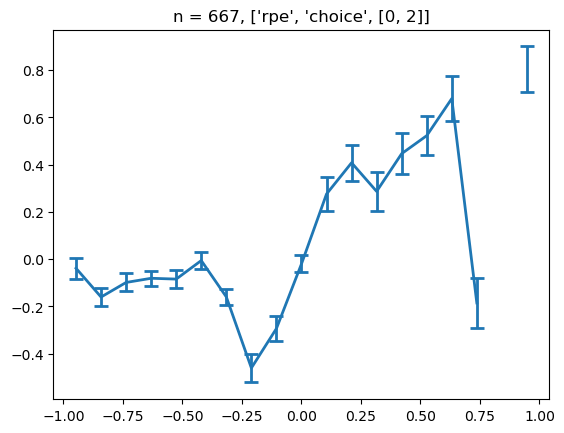

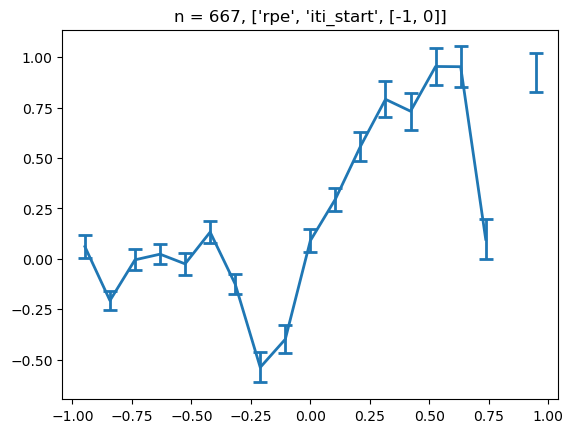

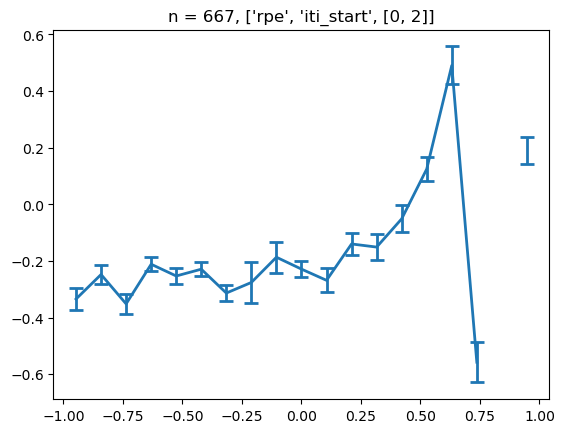

In [11]:
for name, setting in z_tuning_mappper.items():
    print(name)
    df = compute_unit_firing_binned_by_latent_variable(df_aligned_spikes, df_behavior, **setting)
    plot_population_tuning(*compute_group_tuning(df, 
                                                unit_keys=None, #df.index[df.r > 0], 
                                                if_z_score_firing=True,
                                                significance_level=None,
                                                if_flip_tuning=False if df._metadata['latent_name'] == 'rpe' else True), **df._metadata)

In [12]:
df._metadata

{'align_to': 'iti_start',
 'time_win': [0, 2],
 'latent_name': 'rpe',
 'latent_variable_offset': 0,
 'if_z_score_latent': False}

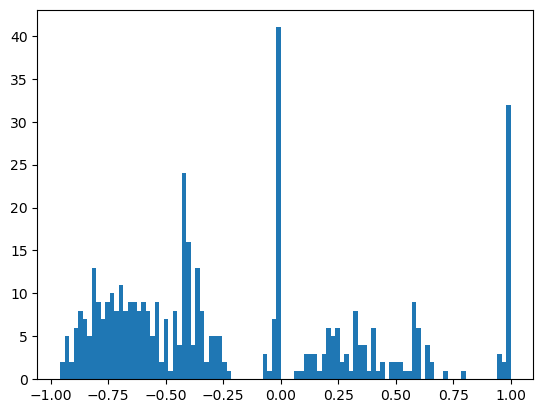

In [143]:
plt.hist(df_behavior['rpe'].astype(float), 100);

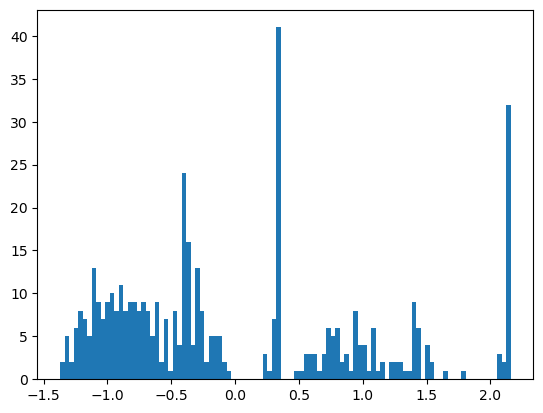

In [87]:
plt.hist(scipy.stats.zscore(df_behavior['rpe'].astype(float), nan_policy='omit'), 100);

In [54]:
unit_keys = df_unit_latent_bin_firing.index
selected_tuning = df_unit_latent_bin_firing.loc[unit_keys, 'mean']
if if_z_score_firing:
    selected_tuning = selected_tuning.apply(scipy.stats.zscore, axis=1, nan_policy='omit')
    
if if_flip_tuning:
    to_flip = df_unit_latent_bin_firing['r'] < 0
    selected_tuning.loc[to_flip] = np.array(selected_tuning.loc[to_flip])[:, ::-1]

tuning_mean = selected_tuning.mean(axis=0)
tuning_sem = selected_tuning.sem(axis=0)


In [ ]:
# average and sem across significant neurons only, separately for negative and positive
sign_level = 0.05
sign_p = pearson_p < sign_level
neg_r = (pearson_r < 0)
pos_r = (pearson_r >= 0)

pop_bin_neg_r_raw_firing_mean = np.mean(unit_bin_firing_mean[neg_r & sign_p, :], axis=0)
pop_bin_neg_r_raw_firing_sem = scipy.stats.sem(unit_bin_firing_mean[neg_r & sign_p, :], axis=0)
pop_bin_pos_r_raw_firing_mean = np.mean(unit_bin_firing_mean[pos_r & sign_p, :], axis=0)
pop_bin_pos_r_raw_firing_sem = scipy.stats.sem(unit_bin_firing_mean[pos_r & sign_p, :], axis=0)


unit_bin_flipped_firing_mean = np.concatenate([unit_bin_firing_mean[pos_r, :], 
                                               unit_bin_firing_mean[neg_r, ::-1]], 
                                               axis=0)

pop_bin_sign_flipped_raw_firing_mean = np.mean(, 
                                               axis=0)